In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    # "tensorflow", # for open ai pretrained wights
]

for p in pkgs:
    print(f"{p}: {version(p)}")

matplotlib: 3.10.5
numpy: 2.3.2
tiktoken: 0.9.0
torch: 2.2.2


In [2]:
from gpt_helpers import GPTModel

GPT_CONFIG_124M = {
    'vocab_size': 50257,  # vocab size
    'context_length': 256,  # context length
    'emb_dim': 768,  # embedding dimension
    'n_layers': 12,  # number of transformer blocks
    'n_heads': 12,  # number of attention heads
    'drop_rate': 0.1,  # dropout rate
    'qkv_bias': False,  # whether to use bias in the query, key, and value weights
}


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/slackroo/Data_science/LLM/llm_from_scratch/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/slackroo/Data_science/LLM/llm_from_scratch/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/slackroo/Data_science/LLM/llm_from_scratch/.venv/lib/python3.11/sit

In [3]:
import torch

torch.manual_seed(456)

model = GPTModel(GPT_CONFIG_124M)
# model.eval()    # this shows the model architecture
model.eval();


In [4]:
import tiktoken
from gpt_helpers import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  #adding batch dimension for the current architecture
    return encoded_tensor




In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)
print(token_ids)

tensor([[6109, 3626, 6100,  345]])


In [6]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you


In [7]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print(token_ids.squeeze(0))

tensor([ 6109,  3626,  6100,   345, 13443, 37191, 25420, 23390, 35735, 37542,
        27518, 24287, 31523,  8074])


In [8]:
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you vague trousers deepest cyclistsurnal rpm discourage northeast breaches Hom


In [9]:
print(token_ids[0, :5])

tensor([ 6109,  3626,  6100,   345, 13443])


# 5.1.2 calculating the text generation loss: Cross entropy  and perplexity

In [10]:
print(text_to_token_ids("every effort moves", tokenizer))
print(text_to_token_ids("I really like", tokenizer))
print(text_to_token_ids(" effort moves you", tokenizer))
print(text_to_token_ids(" really like chocolate", tokenizer))

tensor([[16833,  3626,  6100]])
tensor([[  40, 1107,  588]])
tensor([[3626, 6100,  345]])
tensor([[ 1107,   588, 11311]])


In [11]:
# lets look at some example of logits

inputs = torch.tensor([[16833, 3626, 6100],
                       [40, 1107, 588]])

targets =  torch.tensor([[3626, 6100,  345],
                         [ 1107,   588, 11311]])



In [12]:
with torch.no_grad():
    logits = model(inputs)

print(logits.shape)


torch.Size([2, 3, 50257])


In [13]:
probas = torch.softmax(logits, dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [14]:
probas

tensor([[[1.5637e-05, 5.7691e-05, 6.2597e-05,  ..., 1.7882e-05,
          1.6705e-05, 1.5272e-05],
         [1.5244e-05, 1.2207e-05, 2.5086e-05,  ..., 1.1783e-05,
          1.5645e-05, 1.5306e-05],
         [1.7312e-05, 6.8765e-05, 1.0261e-05,  ..., 1.9064e-05,
          2.3313e-05, 1.9704e-05]],

        [[1.0964e-05, 2.4615e-05, 3.3088e-05,  ..., 9.7370e-06,
          4.9542e-06, 4.2242e-05],
         [7.6122e-06, 1.5710e-05, 5.3961e-05,  ..., 1.1088e-05,
          1.7431e-05, 1.1257e-05],
         [1.2937e-05, 6.1834e-06, 6.7389e-06,  ..., 1.4765e-05,
          8.9612e-06, 2.8780e-05]]])

In [15]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)
# token_ids_to_text(preds, tokenizer)

Token IDs:
 tensor([[[ 5365],
         [13774],
         [30197]],

        [[41229],
         [31634],
         [ 7710]]])


In [16]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"ouputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
ouputs batch 1:  relatively crying Northwestern


In [17]:
# targets[txt_idx]

In [18]:
# what iss the probability of the target token for the target ( actually what it should have been )
txt_idx = 0
target_probas1  = probas[txt_idx, [0,1,2], targets[txt_idx]]
print("text 1:", target_probas1)
# ideally we want to increase the above probability score during training

text 1: tensor([2.7467e-05, 6.1473e-05, 1.5830e-05])


In [19]:
# what iss the probability of the target token for the target ( actually what it should have been )
txt_idx = 1
target_probas2  = probas[txt_idx, [0,1,2], targets[txt_idx]]
print("text 2:", target_probas2)

text 2: tensor([3.0948e-05, 2.3746e-05, 8.7063e-06])


In [20]:
# whats the error?
# compute the log probabilities
log_probas  = torch.log(torch.cat((target_probas1, target_probas2)))
print(log_probas)

tensor([-10.5025,  -9.6969, -11.0536, -10.3832, -10.6481, -11.6515])


In [21]:
# negative log likelihood
-1 * torch.mean(log_probas)
# the idea is to make this close to zero

tensor(10.6560)

In [22]:
print(torch.log(torch.tensor([1.0])))
print(torch.log(torch.tensor([0.00000000000003])))

tensor([0.])
tensor([-31.1376])


In [23]:
logits.shape

torch.Size([2, 3, 50257])

In [24]:
logits_flat = logits.flatten(0,1)
logits_flat.shape

torch.Size([6, 50257])

In [25]:
targets_flat = targets.flatten(0,1)
targets_flat.shape

torch.Size([6])

In [26]:
targets_flat = targets.flatten(0,1)
targets_flat.shape


torch.Size([6])

In [27]:
# pytorch shortcut

torch.nn.functional.cross_entropy(logits_flat,targets_flat)

tensor(10.6560)

# Calculating the loss

In [28]:
import os
import urllib.request

with open('docs/the-verdict.txt','r',encoding='utf-8') as f:
    raw_text=f.read()

In [29]:
raw_text[:100]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g'

In [30]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))

print(f"Total Characters: {total_characters}")
print(f"Total Tokens: {total_tokens}")

Total Characters: 20479
Total Tokens: 5145


In [31]:
# split the data to training set and validation set

from gpt_helpers import create_dataloaderV1

# Train/Validation ratio
train_ratio = 0.90
split_idx  = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]


In [32]:
torch.manual_seed(123)

train_loader = create_dataloaderV1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader  = create_dataloaderV1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)



In [33]:
print("Train loader")

for x,y in train_loader:
    pass
print(x.shape, y.shape)

Train loader
torch.Size([2, 256]) torch.Size([2, 256])


In [34]:
print("Validation loader")

for x,y in val_loader:
    pass
print(x.shape, y.shape)

Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [35]:
x.numel()

512

In [36]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("train tokens:", train_tokens)
print("val tokens:", val_tokens)
print("all tokens:", train_tokens + val_tokens)

train tokens: 4608
val tokens: 512
all tokens: 5120


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [38]:
len(train_loader)

9

In [39]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the dataloader
        # if num_batches excceds the number of batches in  the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches



In [40]:
# for reproducability due to thee shuffling in the dataloader
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

train loss: 10.9898, val loss: 10.9956


#  Perplexity

In [41]:
# perplexity score, it basically says how unsure the model is about the words it predicts
torch.exp(torch.tensor(train_loss))

tensor(59267.2891)

# training the LLM

In [42]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [43]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

In [44]:
num_epochs = 10
train_losses, val_losses, token_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

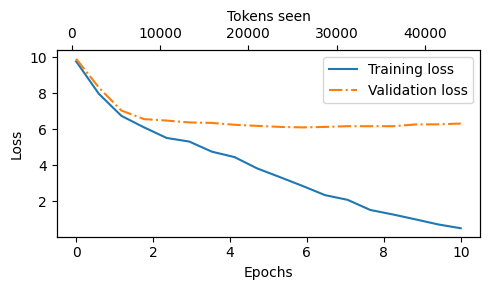

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen.tolist(), train_losses, label="Training loss")
    ax1.plot(epochs_seen.tolist(), val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)